In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle

import bacco
import baccoemu
import PolyBin3D as pb

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-06-02 15:21:11.893729: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 15:21:12.006282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-02 15:21:12.006322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-02 15:21:12.021334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 15:21:12.056823: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [3]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr
            ]
inf_methods = ['sbi']*len(tags_inf)
labels_extra = [
                r'$P(k)$',
                r'$B(k_1,k_2,k_3)$',
                r'$P(k) + B(k_1,k_2,k_3)$',
                ]
colors = ['cyan', 'orange', 'red']

In [4]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary = [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

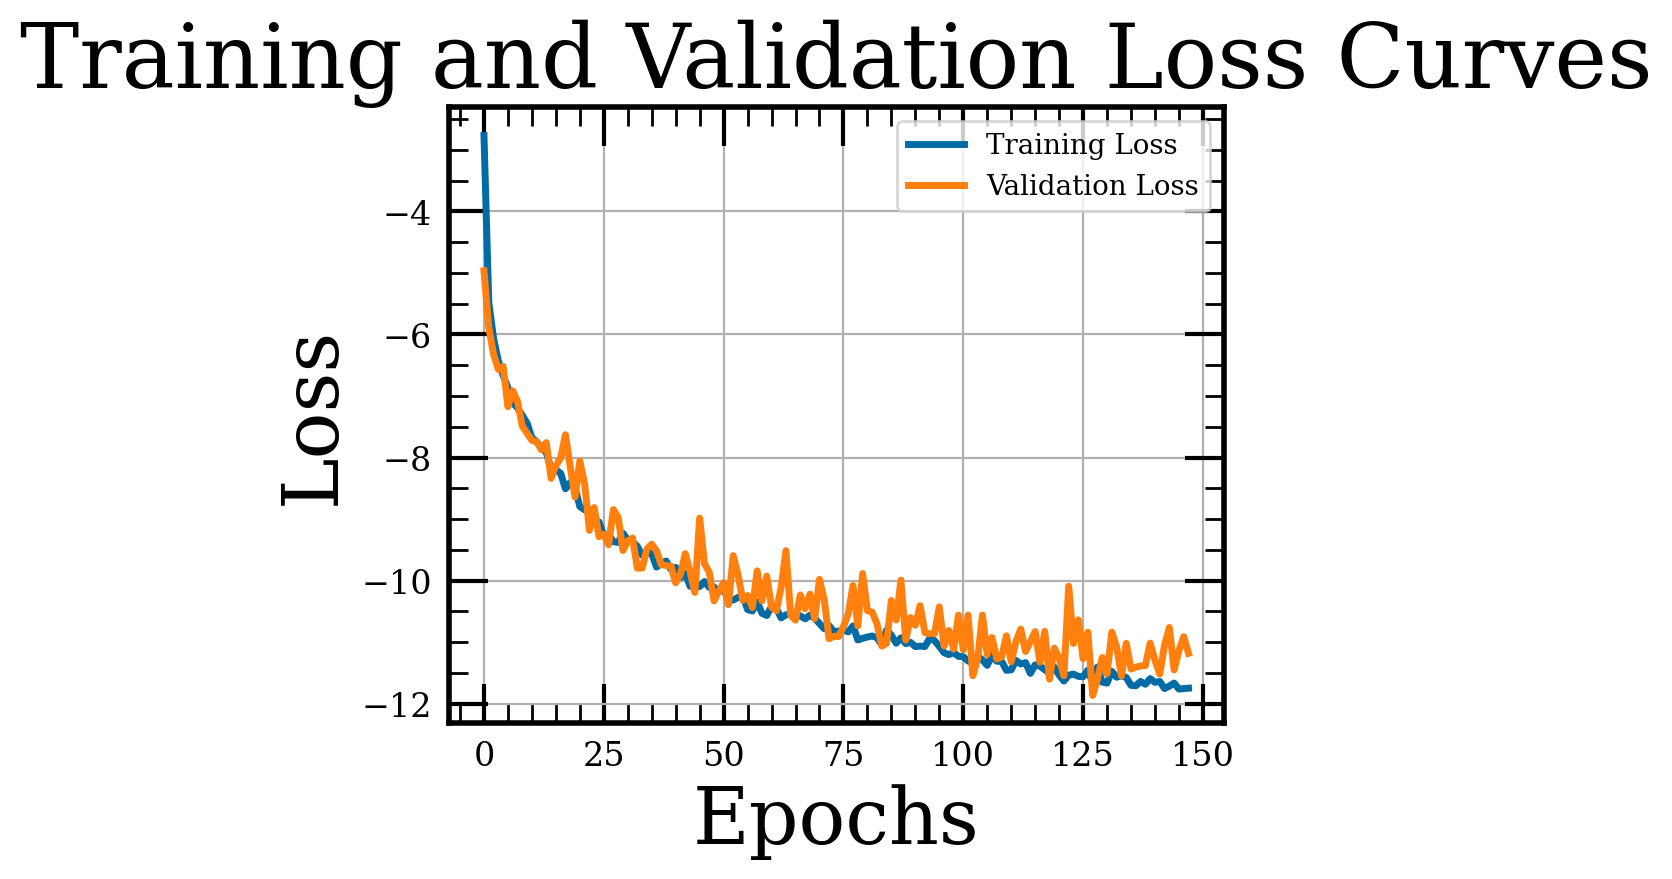

In [5]:
import pickle
dir_sbi = f'../results/results_sbi/sbi{tags_inf[1]}'

fn_inference = f'{dir_sbi}/inference.p'
with open(fn_inference, "rb") as f:
    inference = pickle.load(f)
# Extract training and validation loss
training_loss = inference._summary["training_loss"]
validation_loss = inference._summary["validation_loss"]

# Plot the loss curves
plt.figure(figsize=(5, 4))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend(fontsize=10)
#plt.ylim(-10.5, -10)
plt.grid(True)

In [6]:
# load fixed-cosmo test set
tag_params_test = '_quijote_p0_n1000'
tag_biasparams_test = '_b1000_p0_n1'
tag_datagen_test = ''
theta_test_fixed = data_loader.load_theta_test(tag_params_test, tag_biasparams_test, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test_fixed.shape)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}

(9,)


[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
(10000, 1, 9)
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n10000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
(10000, 1, 9)
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
(10000, 1, 9)


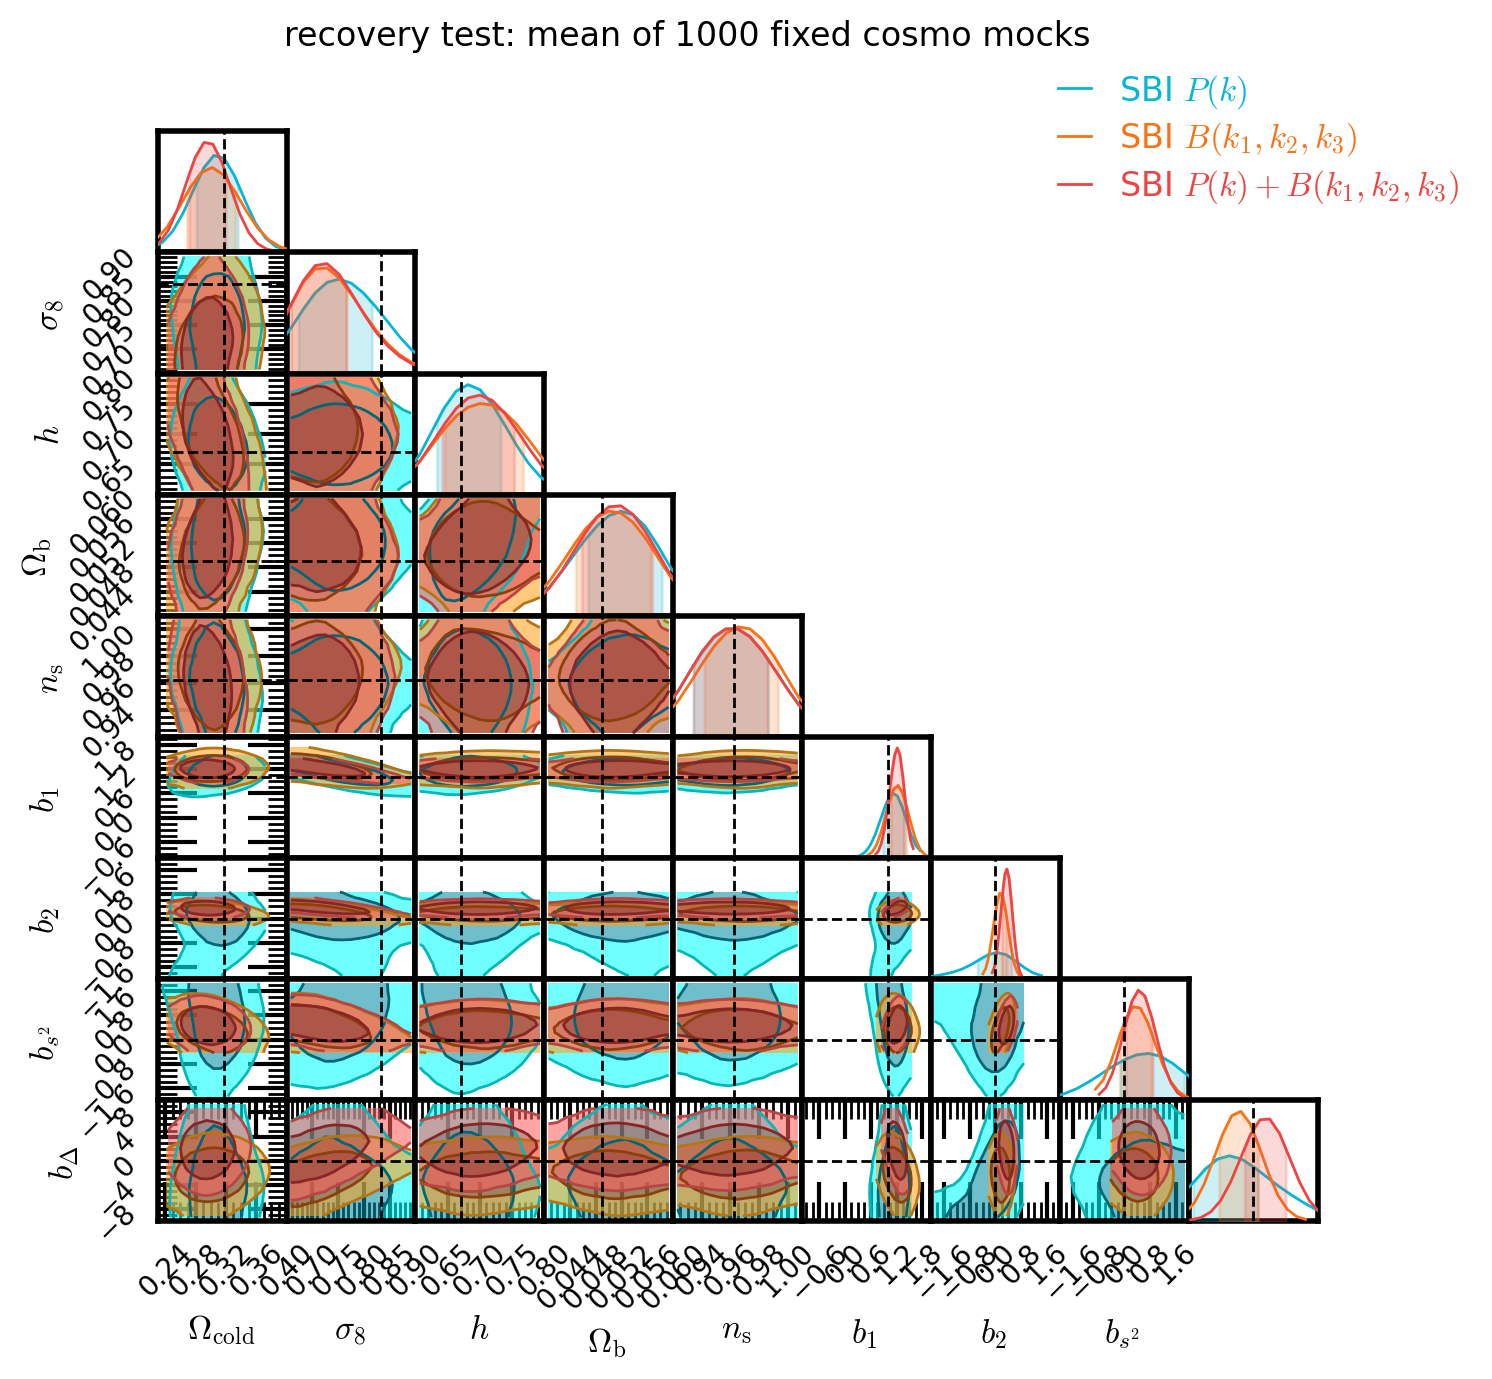

In [7]:
print(theta_test_fixed)
print(param_names_vary)
idx_obs = 0
title = 'recovery test: mean of 1000 fixed cosmo mocks'
tags_test = ['_'+data_mode + tag_stats + tag_params_test + tag_biasparams_test + tag_datagen_test + '_mean' for tag_stats in tag_stats_arr]


#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
theta_test_fixed_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_show]]
plotter.plot_contours_inf(param_names_show, idx_obs, theta_test_fixed_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels_extra=labels_extra,
                        title=title, extents=extents)

In [8]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tag_datagen_test = ''               

tags_data_test = ['_'+data_mode + tag_stats + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i, tag_stats in enumerate(tag_stats_arr)]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000


In [9]:
param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

(10000, 1000, 9)
(10000, 1000, 9)
(10000, 1000, 9)


In [10]:
param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered

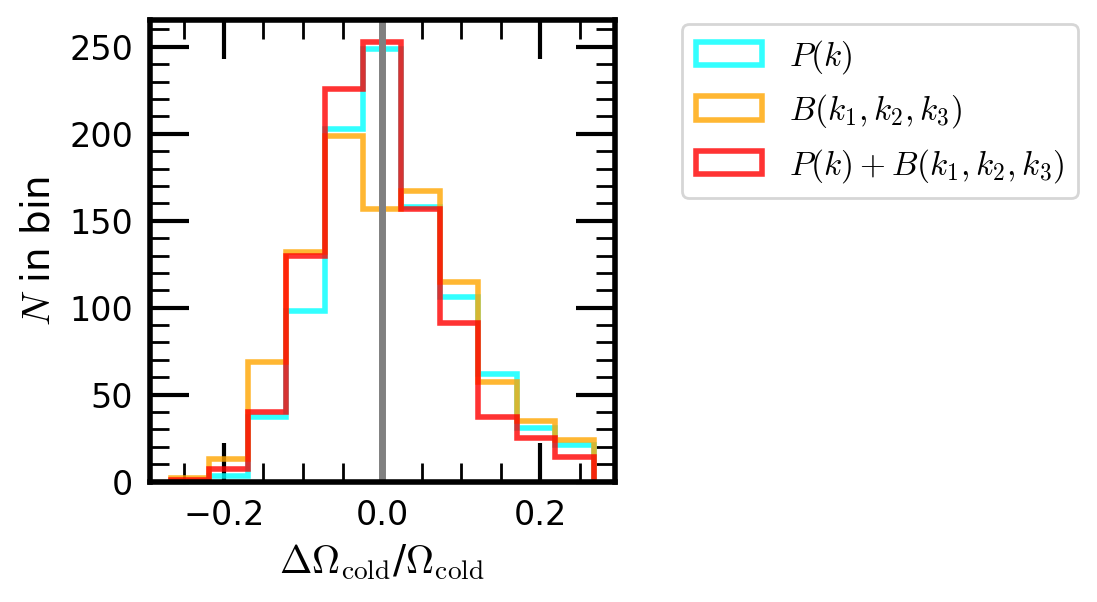

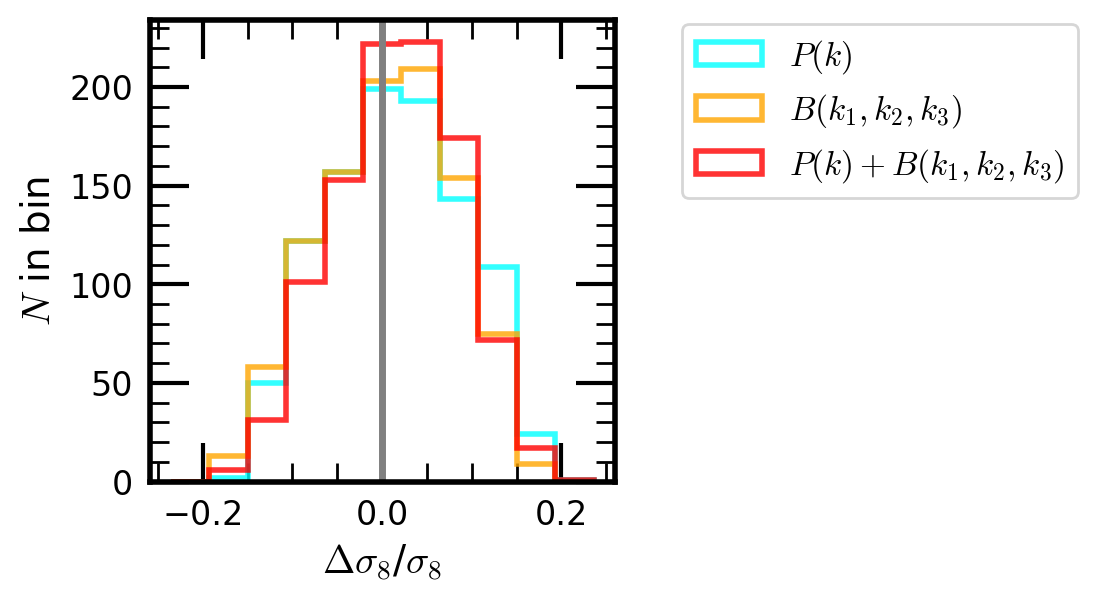

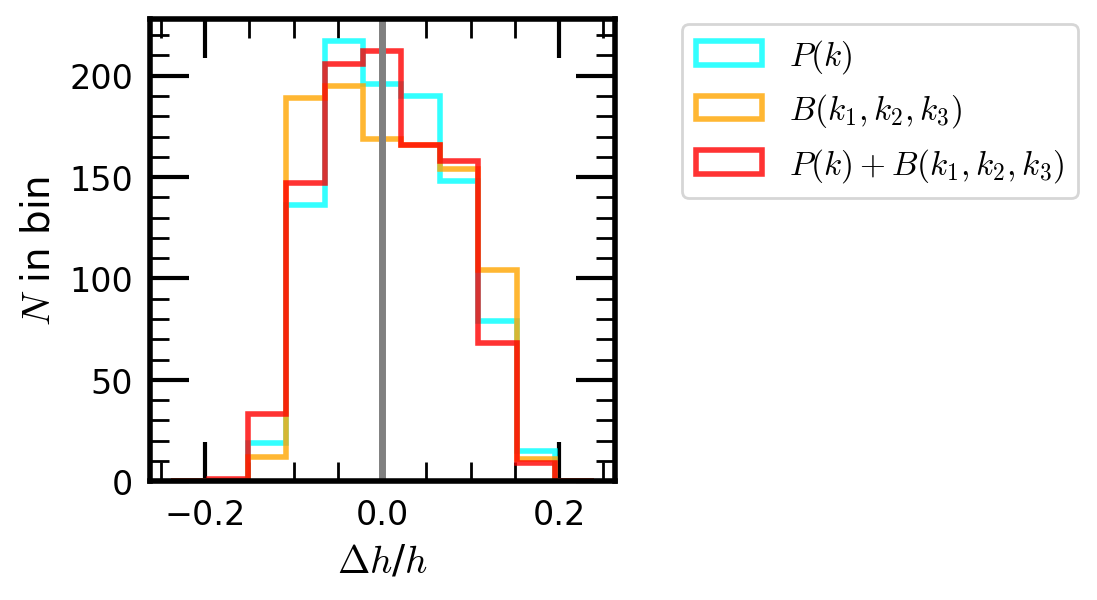

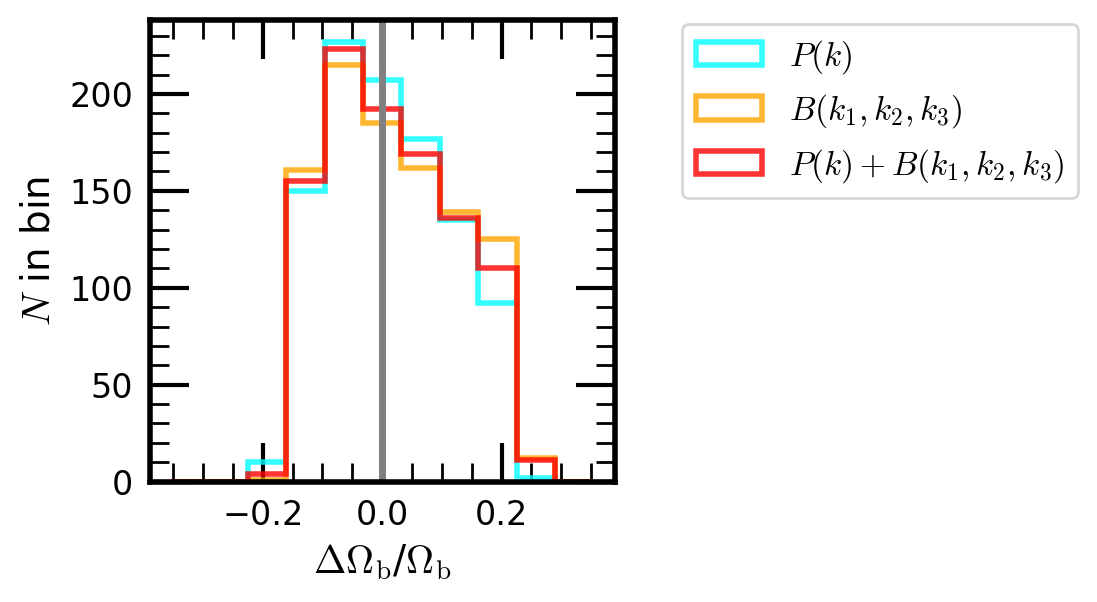

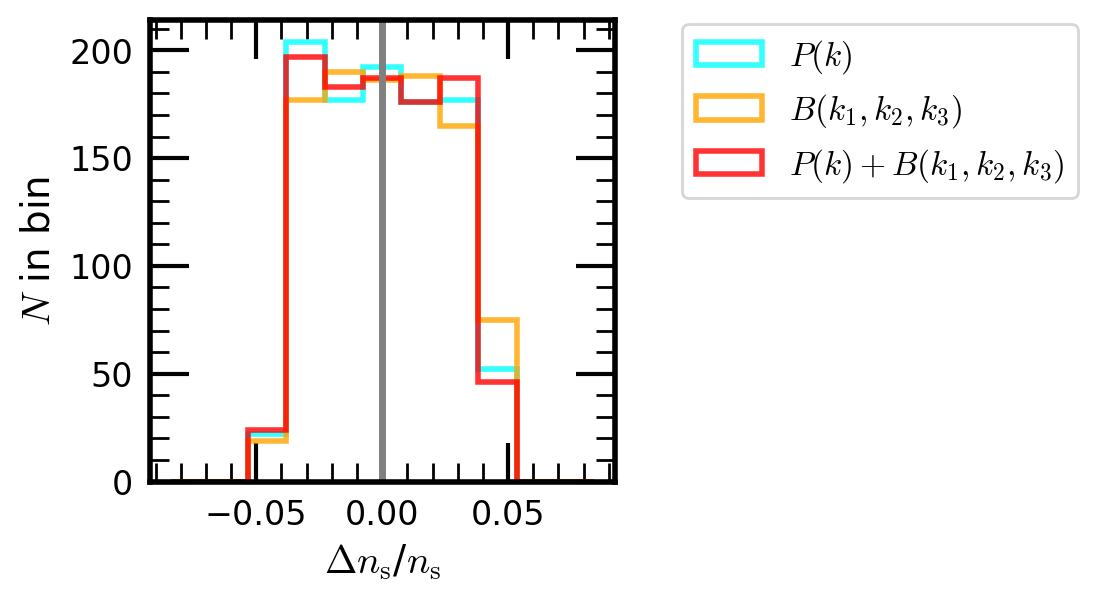

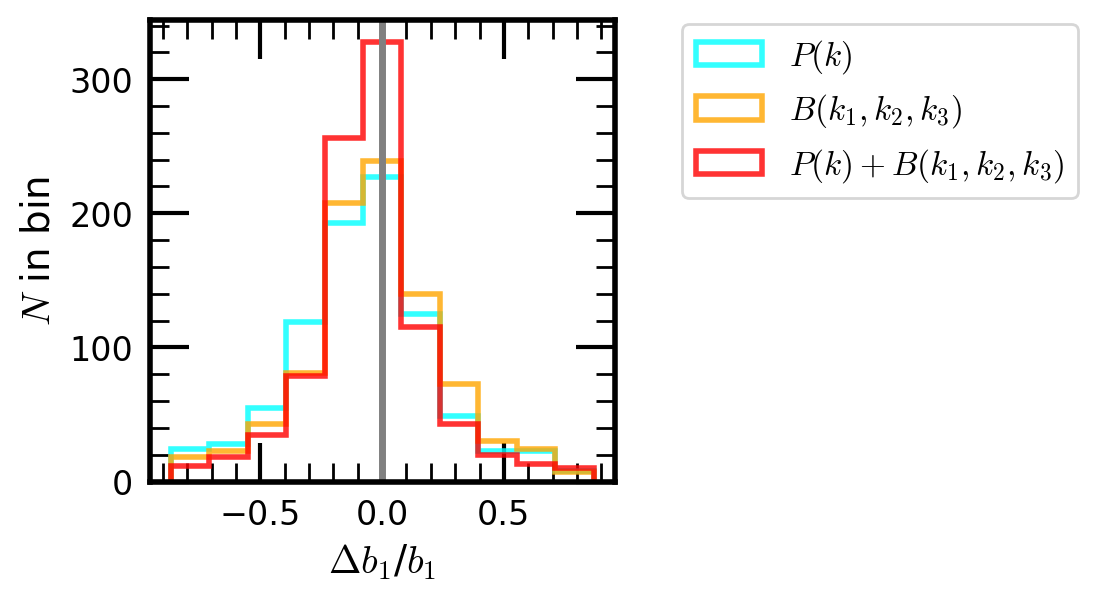

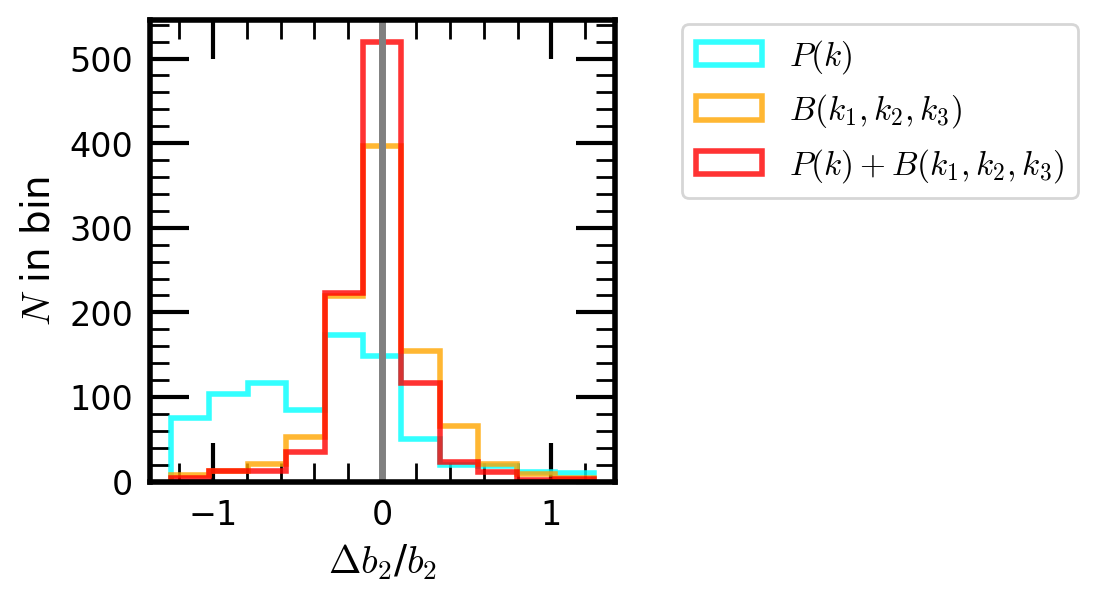

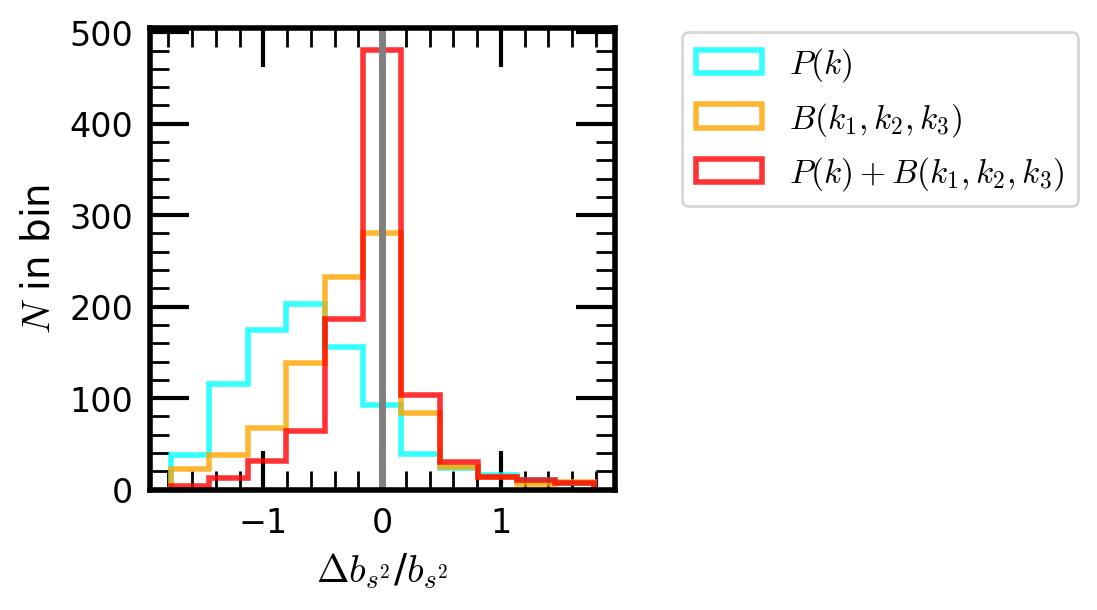

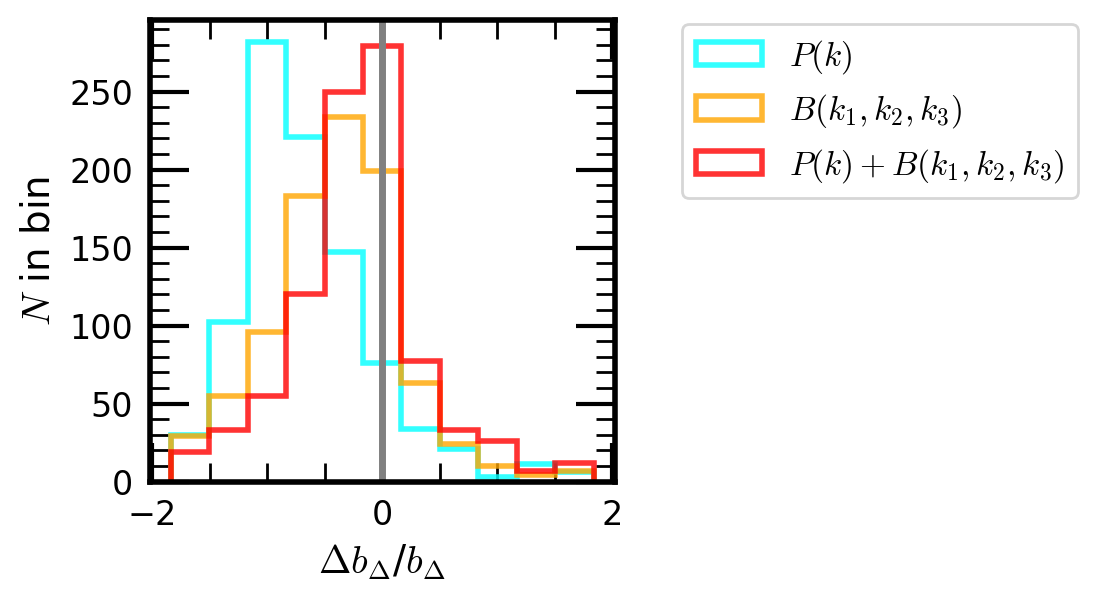

In [11]:
param_labels = [utils.param_label_dict[pns] for pns in param_names_show]
plotter.plot_hists_mean(theta_pred_arr, theta_true_arr, param_labels, 
                        color_arr=colors, label_arr=labels_extra,
                        n_bins=12, alpha=0.8, histtype='step',
                        xlim_auto=False)